## The challenge:

In this competition you’ll predict what types of trees there are in an area based on various geographic features.

The competition datasets comes from a study conducted in four wilderness areas within the beautiful Roosevelt National Forest of northern Colorado. These areas represent forests with very little human disturbances – the existing forest cover types there are more a result of ecological processes rather than forest management practices.

The data is in raw form and contains categorical data such as wilderness areas and soil type.

## Import Packages

In [31]:
DATA_DIR = '/kaggle/input/learn-together'
DATA_DIR = 'data'

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/train.csv
data/test.csv
data/sample_submission.csv
data/sample_submission.csv.zip
data/input
data/test.csv.zip
data/train.csv.zip


## Load Dataset

In [33]:
train_df=pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_df=pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

In [34]:
train_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [35]:
test_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,...,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,...,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,...,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,...,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,...,0,0,0,0,0,0,0,0,0,0


In [36]:
print("shape training csv: %s" % str(train_df.shape)) 
print("shape test csv: %s" % str(test_df.shape)) 

shape training csv: (15120, 56)
shape test csv: (565892, 55)


## Delete Ids
**Let's delete the Id column in the training set but store it for the test set before deleting**

In [37]:
train_df = train_df.drop(["Id"], axis = 1)

test_ids = test_df["Id"]
test_df = test_df.drop(["Id"], axis = 1)

# Feature engineering

In [38]:

def new_features(df):
    df = df.copy()
    df['Hydro_Elevation_diff'] = df[['Elevation',
                                   'Vertical_Distance_To_Hydrology']
                                  ].diff(axis='columns').iloc[:, [1]]

    df['Hydro_Euclidean'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 +
                                   df['Vertical_Distance_To_Hydrology']**2)

    df['Hydro_Fire_sum'] = df[['Horizontal_Distance_To_Hydrology',
                             'Horizontal_Distance_To_Fire_Points']
                            ].sum(axis='columns')

    df['Hydro_Fire_diff'] = df[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Fire_Points']
                             ].diff(axis='columns').iloc[:, [1]].abs()

    df['Hydro_Road_sum'] = df[['Horizontal_Distance_To_Hydrology',
                             'Horizontal_Distance_To_Roadways']
                            ].sum(axis='columns')

    df['Hydro_Road_diff'] = df[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Roadways']
                             ].diff(axis='columns').iloc[:, [1]].abs()

    df['Road_Fire_sum'] = df[['Horizontal_Distance_To_Roadways',
                            'Horizontal_Distance_To_Fire_Points']
                           ].sum(axis='columns')

    df['Road_Fire_diff'] = df[['Horizontal_Distance_To_Roadways',
                             'Horizontal_Distance_To_Fire_Points']
                            ].diff(axis='columns').iloc[:, [1]].abs()
    df['Stoneyness'] = sum(i * df['Soil_Type{}'.format(i)] for i in range(1, 41))

    # For all 40 Soil_Types, 1=rubbly, 2=stony, 3=very stony, 4=extremely stony, 0=?
    stoneyness = [4, 3, 1, 1, 1, 2, 0, 0, 3, 1, 
                  1, 2, 1, 0, 0, 0, 0, 3, 0, 0, 
                  0, 4, 0, 4, 4, 3, 4, 4, 4, 4, 
                  4, 4, 4, 4, 1, 4, 4, 4, 4, 4]

    # Replace Soil_Type number with "stoneyness" value
    df['Stoneyness'] = df['Stoneyness'].replace(range(1, 41), stoneyness)
    return df
    
def drop_features(df):
    df = df.copy()
    columns_to_drop = []
    size = len(df)
    for column in df.columns:
        frequency = df[column].sum() / size
        if 'Soil' in column and frequency < 0.04:
            columns_to_drop.append(column)
    df = df.drop(columns_to_drop, axis='columns')
    return df
    

In [39]:
X = new_features(train_df)
X = drop_features(X)
X_test = new_features(test_df)
X_test = X_test[X.columns.drop(['Cover_Type'])]


In [40]:
X_train, y_train = X.drop(['Cover_Type'], axis=1), train_df['Cover_Type']

In [41]:
X.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Cover_Type,Hydro_Elevation_diff,Hydro_Euclidean,Hydro_Fire_sum,Hydro_Fire_diff,Hydro_Road_sum,Hydro_Road_diff,Road_Fire_sum,Road_Fire_diff,Stoneyness
0,2596,51,3,258,0,510,221,232,148,6279,...,5,-2596.0,258.000000,6537,6021.0,768,252.0,6789,5769.0,4
1,2590,56,2,212,-6,390,220,235,151,6225,...,5,-2596.0,212.084889,6437,6013.0,602,178.0,6615,5835.0,4
2,2804,139,9,268,65,3180,234,238,135,6121,...,2,-2739.0,275.769832,6389,5853.0,3448,2912.0,9301,2941.0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,2,-2667.0,269.235956,6453,5969.0,3332,2848.0,9301,3121.0,4
4,2595,45,2,153,-1,391,220,234,150,6172,...,5,-2596.0,153.003268,6325,6019.0,544,238.0,6563,5781.0,4


In [42]:
X.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Cover_Type,Hydro_Elevation_diff,Hydro_Euclidean,Hydro_Fire_sum,Hydro_Fire_diff,Hydro_Road_sum,Hydro_Road_diff,Road_Fire_sum,Road_Fire_diff,Stoneyness
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,4.000000,-2698.246032,235.948778,1738.342989,1291.834788,1941.218915,1492.094577,3225.170503,897.908333,2.333003
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,2.000066,414.680029,215.491695,1152.123001,1077.167415,1383.173588,1292.673425,2093.672478,884.718318,1.580487
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,1.000000,-3776.000000,0.000000,30.000000,0.000000,30.000000,0.000000,95.000000,0.000000,0.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,2.000000,-3068.000000,67.186308,903.000000,532.000000,967.000000,534.000000,1806.000000,291.000000,1.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,4.000000,-2696.000000,188.480768,1462.000000,1023.500000,1501.000000,1148.000000,2520.500000,632.000000,2.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,6.000000,-2323.000000,342.069071,2302.000000,1726.000000,2554.000000,2042.000000,4232.250000,1220.000000,4.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,7.000000,-1842.000000,1356.939571,7167.000000,6898.000000,7306.000000,6860.000000,12504.000000,6012.000000,4.000000


## Cluster features

In [43]:
# TODO: add cluster features, do elbow method

In [44]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
ss = StandardScaler()
cluster_data = ss.fit_transform(X_train)
cluster_data_test = ss.fit_transform(X_test)

In [45]:
km = KMeans(17)
km.fit(np.vstack([cluster_data_test, cluster_data]))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=17, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [46]:
X_train['cluster'] = km.predict(cluster_data)
X_test['cluster'] = km.predict(cluster_data_test)

In [21]:
n_components = [r for r in range(6, 21)]
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cluster_data)
          for n in n_components]

Text(0.5, 0, 'n_components')

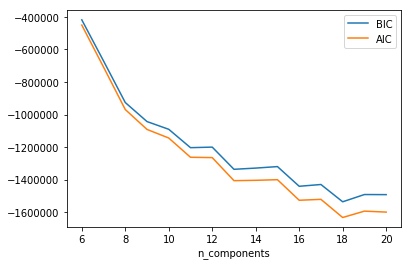

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(n_components, [m.bic(X_train) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [34]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from collections import OrderedDict

# TODO: Apply your clustering algorithm of choice to the reduced data
def make_cluster(clusterer, X):
    # clusterer.fit(reduced_data)
    preds = clusterer.fit_predict(X)
    score = silhouette_score(X, preds)
    return clusterer, score

kclusters = OrderedDict()
kscores = OrderedDict()
for n in range(2, 19):
    kmeans = KMeans(n_clusters=n, random_state=13)
    kclusters[n], kscores[n] = make_cluster(kmeans, X_train)
   
gclusters = OrderedDict()
gscores = OrderedDict()
for n in range(2, 19):
    gaussian = GaussianMixture(n_components=n, 
                               covariance_type='full', 
                               random_state=13)
    gclusters[n], gscores[n] = make_cluster(gaussian, X_train)

   

Text(0.5, 0, 'scores')

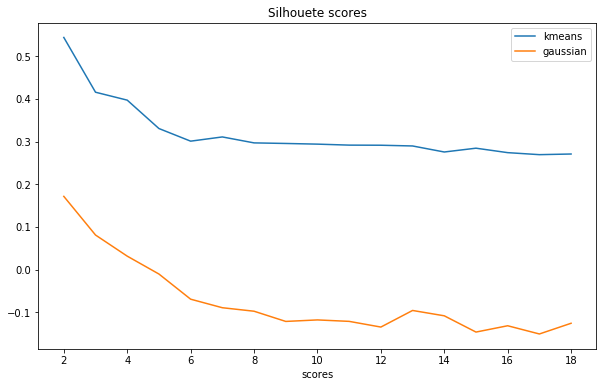

In [35]:
plt.figure(figsize=(10, 6))
plt.title('Silhouete scores')
plt.plot(kscores.keys(), kscores.values(), label='kmeans')
plt.plot(gscores.keys(), gscores.values(), label='gaussian')
plt.legend()
plt.xlabel('number of clusters')
plt.xlabel('scores')

# Brute Force parameters search

In [13]:
# A simple first test to validate features of actual df


etc = ExtraTreesClassifier(
    bootstrap=True, oob_score=True,
    **{'max_depth': 60, 'n_estimators': 200, 'max_features': 0.8}
    )
etc.fit(X_train, y_train)
etc.oob_score_

0.8976851851851851

In [50]:
from time import time
from sklearn.model_selection import RandomizedSearchCV



In [38]:
param_dist = {"max_depth": [5, 10, 15, 25, 40, 80],
              'max_features': [0.2, 0.4, 0.6, 0.8],
              'n_estimators': [20, 50, 100, 200, 600, 1200, 2000, 2400]
             }


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
n_iter_search = 5
random_search = RandomizedSearchCV(ExtraTreesClassifier(bootstrap=False), param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 313.60 seconds for 5 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.801 (std: 0.037)
Parameters: {'max_features': 0.6, 'n_estimators': 2000, 'max_depth': 25}

Model with rank: 2
Mean validation score: 0.786 (std: 0.039)
Parameters: {'max_features': 0.2, 'n_estimators': 2400, 'max_depth': 80}

Model with rank: 3
Mean validation score: 0.783 (std: 0.039)
Parameters: {'max_features': 0.2, 'n_estimators': 1200, 'max_depth': 25}



In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_e, y_e, test_size=0.2)

In [46]:
etc = ExtraTreesClassifier(
    bootstrap=True, oob_score=True,
    class_weight= {1:1000, 2: 1000, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1},
    **{'max_depth': 32, 'n_estimators': 2200, 'max_features': 0.7}
    )
etc.fit(X_train, y_train)
etc.oob_score_

0.8716931216931217

In [47]:
y_pred = etc.predict(X_val)
report(y_val, y_pred)

Accuracy: 0.8796296296296297
              precision    recall  f1-score   support

           1       0.84      0.75      0.79       218
           2       0.78      0.70      0.74       193
           3       0.87      0.83      0.85       194
           4       0.95      0.98      0.96       236
           5       0.90      0.97      0.93       235
           6       0.88      0.91      0.89       220
           7       0.91      0.98      0.95       216

    accuracy                           0.88      1512
   macro avg       0.87      0.87      0.87      1512
weighted avg       0.88      0.88      0.88      1512

[[163  32   0   0   5   0  18]
 [ 28 135   2   0  19   7   2]
 [  0   3 161  10   1  19   0]
 [  0   0   4 231   0   1   0]
 [  0   3   3   0 228   1   0]
 [  0   1  15   3   1 200   0]
 [  4   0   0   0   0   0 212]]


In [48]:
# Train with all data, maximizing trees variety (bootstrap False)
etc = ExtraTreesClassifier(
    bootstrap=False,
    class_weight= {1:10000, 2: 10000, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1},
    **{'max_depth': 32, 'n_estimators': 2200, 'max_features': 0.7}
    )
etc.fit(X_e, y_e)
etc.score(X_e, y_e)

0.9986772486772487

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
def report(y_true, y_pred):
    print('Accuracy: %s' % accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

In [39]:
X_1_2 = X_e[y_e < 3]
y_1_2 = y_e[y_e < 3]
X_train, X_val, y_train, y_val = train_test_split(X_1_2, y_1_2, test_size=0.2)
etc = ExtraTreesClassifier(
    bootstrap=False,
    **{'max_depth': 20, 'n_estimators': 3000, 'max_features': 0.6}
    )

etc.fit(X_train, y_train)
y_pred = etc.predict(X_val)

In [40]:
print(etc.score(X_train, y_train))
report(y_val, y_pred)

0.9994212962962963
Accuracy: 0.8171296296296297
              precision    recall  f1-score   support

           1       0.81      0.82      0.81       421
           2       0.83      0.81      0.82       443

    accuracy                           0.82       864
   macro avg       0.82      0.82      0.82       864
weighted avg       0.82      0.82      0.82       864

[[346  75]
 [ 83 360]]


# Mount the ensemble

In [47]:
X_, X_val, y_, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [48]:
y_train.head()

0    5
1    5
2    2
3    2
4    5
Name: Cover_Type, dtype: int64

In [65]:
ss = StandardScaler()
pca = PCA(random_state=60, n_components=12)
knn = KNeighborsClassifier(algorithm='auto',
                           weights='distance',
                           n_jobs=-1,
                           n_neighbors=3)

pipe = Pipeline(steps=[
        ('scale', ss),
        ('pca', pca),
        ('pred', knn)
]).fit(X_, y_)
print(pipe.score(X_, y_))
print(pipe.score(X_val, y_val))

1.0
0.8250661375661376


In [43]:
X_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Hydro_Elevation_diff,Hydro_Euclidean,Hydro_Fire_sum,Hydro_Fire_diff,Hydro_Road_sum,Hydro_Road_diff,Road_Fire_sum,Road_Fire_diff,Stoneyness,cluster
0,2596,51,3,258,0,510,221,232,148,6279,...,-2596.0,258.000000,6537,6021.0,768,252.0,6789,5769.0,4,4
1,2590,56,2,212,-6,390,220,235,151,6225,...,-2596.0,212.084889,6437,6013.0,602,178.0,6615,5835.0,4,4
2,2804,139,9,268,65,3180,234,238,135,6121,...,-2739.0,275.769832,6389,5853.0,3448,2912.0,9301,2941.0,2,6
3,2785,155,18,242,118,3090,238,238,122,6211,...,-2667.0,269.235956,6453,5969.0,3332,2848.0,9301,3121.0,4,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,-2596.0,153.003268,6325,6019.0,544,238.0,6563,5781.0,4,4


### Search for better classifier for class 1 x class2

In [44]:
X_12 = X_train[y_train < 3]
y_12 = y_train[y_train < 3]
X_12, X_val12, y_12, y_val12 = train_test_split(X_12, y_12, test_size=0.2)

In [45]:
etc = ExtraTreesClassifier(
    bootstrap=False,
    # class_weight= {1:10000, 2: 10000}, #, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1},
    **{'max_depth': None, 'n_estimators': 600, 'max_features': 0.8}
    )
etc.fit(X_12, y_12)
print(etc.score(X_12, y_12))
print(etc.score(X_val12, y_val12))
y_pred = etc.predict(X_val12)
confusion_matrix(y_val12, y_pred)

1.0
0.8483796296296297


array([[350,  80],
       [ 51, 383]])

In [46]:
rf = RandomForestClassifier(n_estimators=800, bootstrap=False)
rf.fit(X_12, y_12)
print(rf.score(X_12, y_12))
print(rf.score(X_val12, y_val12))
y_pred = rf.predict(X_val12)
confusion_matrix(y_val12, y_pred)

1.0
0.8402777777777778


array([[352,  78],
       [ 60, 374]])

### Trees Classifiers and ensemble

In [49]:
rf = RandomForestClassifier(n_estimators=800,
                            # class_weight= {0:10, 1:4, 2: 2, 3: 1, 4: 1, 5: 4, 6: 1},
                            bootstrap=False)
# rf.fit(X_, y_)
# print(rf.score(X_, y_))
# print(rf.score(X_val, y_val))

In [50]:
etc = ExtraTreesClassifier(
    bootstrap=False,
    # class_weight= {0:10000, 1: 10000, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1},
    **{'max_depth': 40, 'n_estimators': 1200, 'max_features': 0.7}
    )

In [51]:
!pip install lightgbm
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(n_estimators=400,
                        num_leaves=100)

In [52]:
from mlxtend.classifier import StackingCVClassifier

ensemble = [('rf', rf),
            ('etc', etc),
            ('lgb', lgb)]

stack = StackingCVClassifier(classifiers=[clf for label, clf in ensemble],
                             meta_classifier=rf,
                             cv=5,
                             use_probas=True,
                             use_features_in_secondary=True,
                             verbose=1,
                             random_state=0,
                             n_jobs=-1)



stack.fit(X_, y_)

Fitting 3 classifiers...
Fitting classifier1: randomforestclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.6s remaining:   38.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: extratreesclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.8s remaining:   38.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: lgbmclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.2s remaining:   37.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.5s finished


StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap=False,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimators=800,
                                                         n_jobs

In [53]:
print(stack.score(X_, y_))
print(stack.score(X_val, y_val))

0.999834656084656
0.906084656084656


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = stack.predict(X_val)

In [57]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[334  71   0   0   3   0   6]
 [ 56 363  10   0  14   6   1]
 [  0   1 380  10   1  38   0]
 [  0   0   8 430   0   5   0]
 [  0   6   3   0 402   4   0]
 [  0   0  25   7   0 415   0]
 [  9   0   0   0   0   0 416]]
              precision    recall  f1-score   support

           1       0.84      0.81      0.82       414
           2       0.82      0.81      0.81       450
           3       0.89      0.88      0.89       430
           4       0.96      0.97      0.97       443
           5       0.96      0.97      0.96       415
           6       0.89      0.93      0.91       447
           7       0.98      0.98      0.98       425

    accuracy                           0.91      3024
   macro avg       0.91      0.91      0.91      3024
weighted avg       0.91      0.91      0.91      3024



In [55]:
## Fit with all data

stack.fit(X_train, y_train)


Fitting 3 classifiers...
Fitting classifier1: randomforestclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   30.4s remaining:   45.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: extratreesclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting classifier3: lgbmclassifier (3/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   48.6s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap=False,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimators=800,
                                                         n_jobs

In [58]:
y_pred = stack.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[414   0   0   0   0   0   0]
 [  0 450   0   0   0   0   0]
 [  0   0 430   0   0   0   0]
 [  0   0   0 443   0   0   0]
 [  0   0   0   0 415   0   0]
 [  0   0   0   0   0 447   0]
 [  0   0   0   0   0   0 425]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       414
           2       1.00      1.00      1.00       450
           3       1.00      1.00      1.00       430
           4       1.00      1.00      1.00       443
           5       1.00      1.00      1.00       415
           6       1.00      1.00      1.00       447
           7       1.00      1.00      1.00       425

    accuracy                           1.00      3024
   macro avg       1.00      1.00      1.00      3024
weighted avg       1.00      1.00      1.00      3024



## Predictions

In [56]:
print(X_test.shape)
print(X_train.shape)

(565892, 37)
(15120, 37)


In [59]:
test_pred = stack.predict(X_test)

In [60]:
# Save test predictions to file
output = pd.DataFrame({'ID': test_ids,
                       'Cover_Type': test_pred})
output.to_csv('submission.csv', index=False)